In [23]:
!pip install ultralytics seaborn

In [24]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
import time
from ultralytics import YOLO
import numpy as np

In [17]:
# Load pre-trained YOLOv8n model (using the large model)
model = YOLO('yolov8l.pt')

100%|██████████| 83.7M/83.7M [00:00<00:00, 132MB/s]


Протестируем - всё ли работает как надо

Captured frame 0
Captured frame 1
Captured frame 2
Captured frame 3
Captured frame 4
Captured frame 5


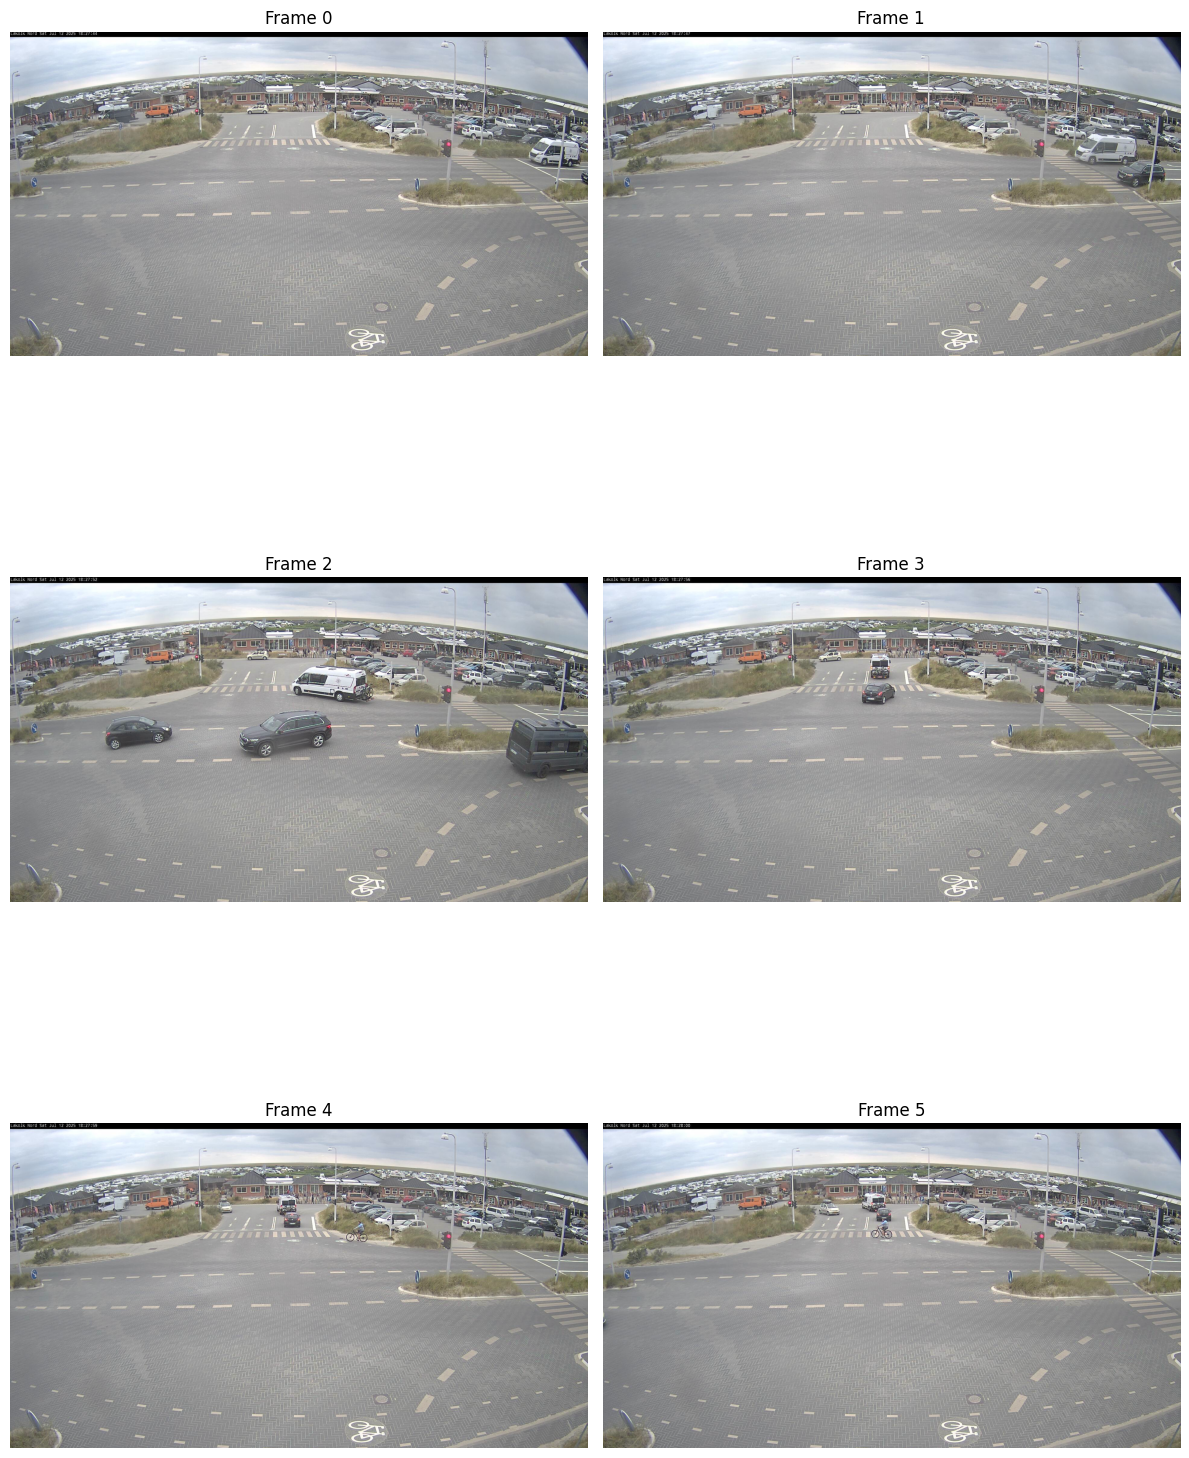

In [8]:
# Actual MJPEG stream URL
stream_url = 'http://212.112.136.4:83/mjpg/video.mjpg?camera=1'

# Open the stream
cap = cv2.VideoCapture(stream_url)

frames = []

for i in range(6):
    ret, frame = cap.read()
    if ret:
        frames.append(frame)
        print(f"Captured frame {i}")
    else:
        print(f"Failed at frame {i}")
    time.sleep(5)  # Wait 5 seconds between captures

cap.release()

# Plot the 6 images in a 3x2 grid
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
axes = axes.flatten()

for idx, (ax, img) in enumerate(zip(axes, frames)):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(f"Frame {idx}")
    ax.axis('off')

plt.tight_layout()
plt.show()

Let's introduce detection into the mix:

In [12]:
# Open the stream
cap = cv2.VideoCapture(stream_url)

annotated_frames = []

for i in range(6):
    ret, frame = cap.read()
    if not ret:
        print(f"Failed at frame {i}")
        time.sleep(5)
        continue

    print(f"Captured frame {i}")

    # Convert to RGB for YOLO
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Run YOLO detection
    results = model(rgb_frame, verbose=False)

    # Annotate only cars (class 2)
    for result in results:
        boxes = result.boxes
        for box in boxes:
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])
            if cls_id == 2 and conf > 0.3:
                xyxy = box.xyxy[0].cpu().numpy().astype(int)
                # Draw box on the frame
                cv2.rectangle(frame, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (0, 255, 0), 2)
                label = f"Car {conf:.2f}"
                cv2.putText(frame, label, (xyxy[0], xyxy[1] - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Save the annotated frame to disk
    filename = f"car_detected_frame_{i}.jpg"
    cv2.imwrite(filename, frame)
    print(f"Saved {filename}")

    # Store for display
    annotated_frames.append(frame)

    # Wait between snapshots
    time.sleep(5)

cap.release()

Captured frame 0
Saved car_detected_frame_0.jpg
Captured frame 1
Saved car_detected_frame_1.jpg
Captured frame 2
Saved car_detected_frame_2.jpg
Captured frame 3
Saved car_detected_frame_3.jpg
Captured frame 4
Saved car_detected_frame_4.jpg
Captured frame 5
Saved car_detected_frame_5.jpg


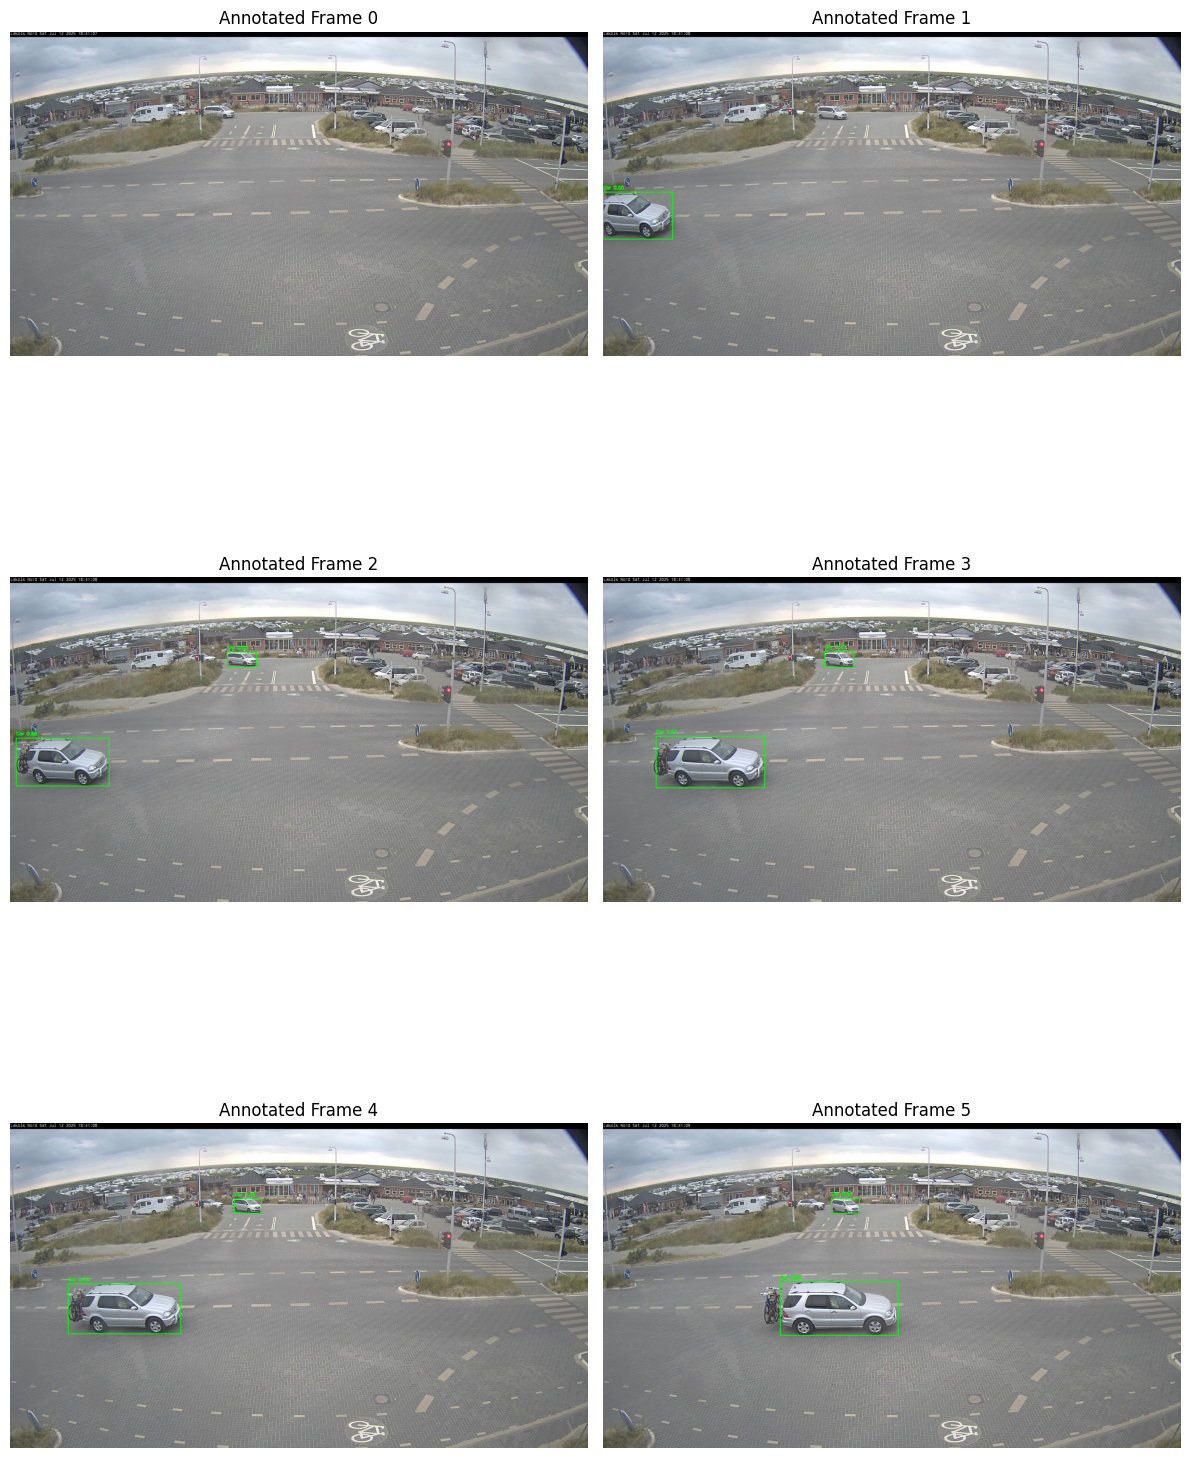

In [13]:
# Plot the saved annotated images
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
axes = axes.flatten()

for idx, (ax, img) in enumerate(zip(axes, annotated_frames)):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(f"Annotated Frame {idx}")
    ax.axis('off')

plt.tight_layout()
plt.show()

Next - let's generate a continious stream, imitating a proper pipeline to see that everything is running as expected:

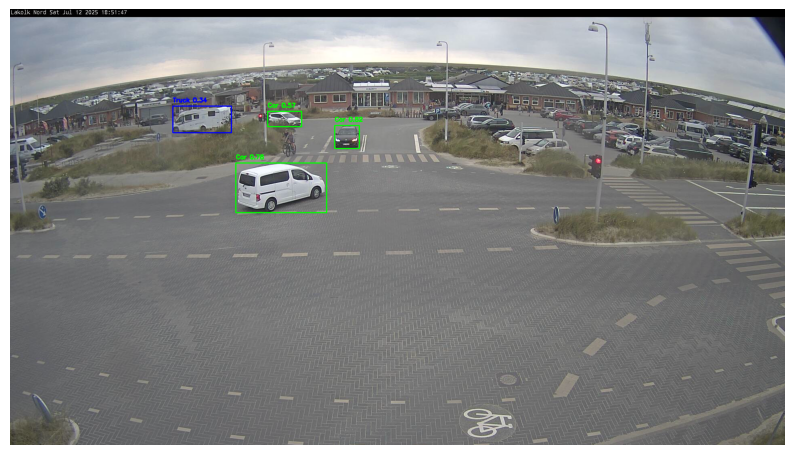

Interrupted manually. Stopping.


In [19]:
# Open stream
cap = cv2.VideoCapture(stream_url)

# Define COCO class IDs we want: cars and trucks
TARGET_CLASSES = [2, 7]  # 2 = car, 7 = truck

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            time.sleep(2)
            continue

        # Convert BGR to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Run YOLO detection
        results = model(rgb_frame, verbose=False)

        # Annotate only cars and trucks
        for result in results:
            boxes = result.boxes
            for box in boxes:
                cls_id = int(box.cls[0])
                conf = float(box.conf[0])
                if cls_id in TARGET_CLASSES and conf > 0.3:
                    xyxy = box.xyxy[0].cpu().numpy().astype(int)
                    # Choose color based on class
                    color = (0, 255, 0) if cls_id == 2 else (255, 0, 0)
                    label_name = "Car" if cls_id == 2 else "Truck"
                    # Draw bounding box
                    cv2.rectangle(frame, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), color, 2)
                    label = f"{label_name} {conf:.2f}"
                    cv2.putText(frame, label, (xyxy[0], xyxy[1] - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Display annotated frame in notebook
        clear_output(wait=True)
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # Wait before next frame
        time.sleep(5)

except KeyboardInterrupt:
    print("Interrupted manually. Stopping.")
finally:
    cap.release()

Works great. As a precaution - let's add all vehicle types into the mix:

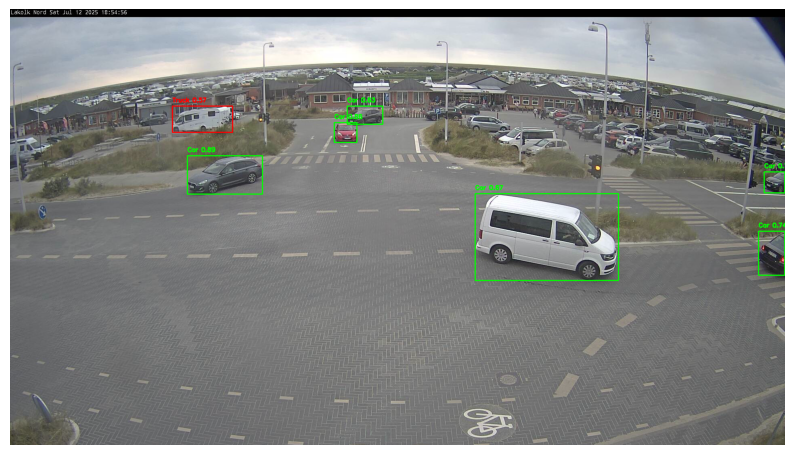

Interrupted manually. Stopping.


In [22]:
# Open stream
cap = cv2.VideoCapture(stream_url)

# Define COCO class IDs for all vehicle types
TARGET_CLASSES = {
    2: ('Car', (0, 255, 0)),         # Green
    3: ('Motorcycle', (255, 255, 0)),# Yellow
    5: ('Bus', (255, 0, 0)),         # Red
    7: ('Truck', (0, 0, 255))        # Blue
}

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            time.sleep(2)
            continue

        # Convert BGR to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Run YOLO detection
        results = model(rgb_frame, verbose=False)

        # Annotate all vehicle types
        for result in results:
            boxes = result.boxes
            for box in boxes:
                cls_id = int(box.cls[0])
                conf = float(box.conf[0])
                if cls_id in TARGET_CLASSES and conf > 0.2:
                    xyxy = box.xyxy[0].cpu().numpy().astype(int)
                    label_name, color = TARGET_CLASSES[cls_id]
                    # Draw bounding box
                    cv2.rectangle(frame, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), color, 2)
                    label = f"{label_name} {conf:.2f}"
                    cv2.putText(frame, label, (xyxy[0], xyxy[1] - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Display annotated frame in notebook
        clear_output(wait=True)
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # Wait before next frame
        time.sleep(5)

except KeyboardInterrupt:
    print("Interrupted manually. Stopping.")
finally:
    cap.release()

Next step - calculating the actual heatmaps, as per project requirements (to save them later on for analytics):

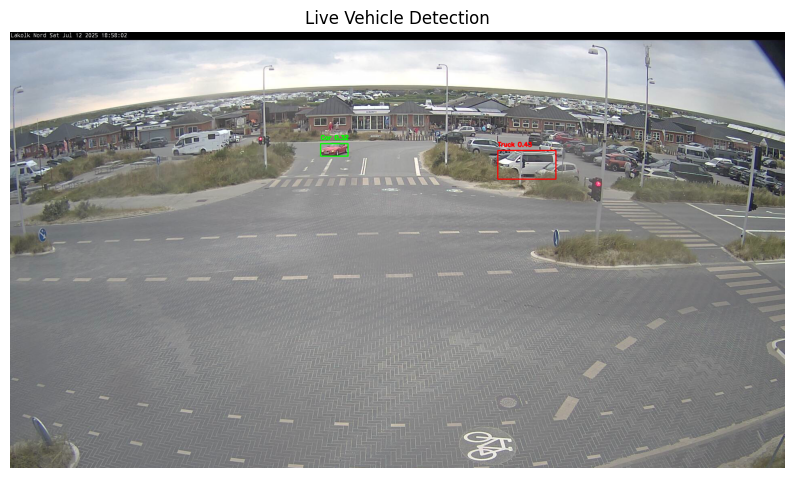

Rendering heatmap with 33 points...


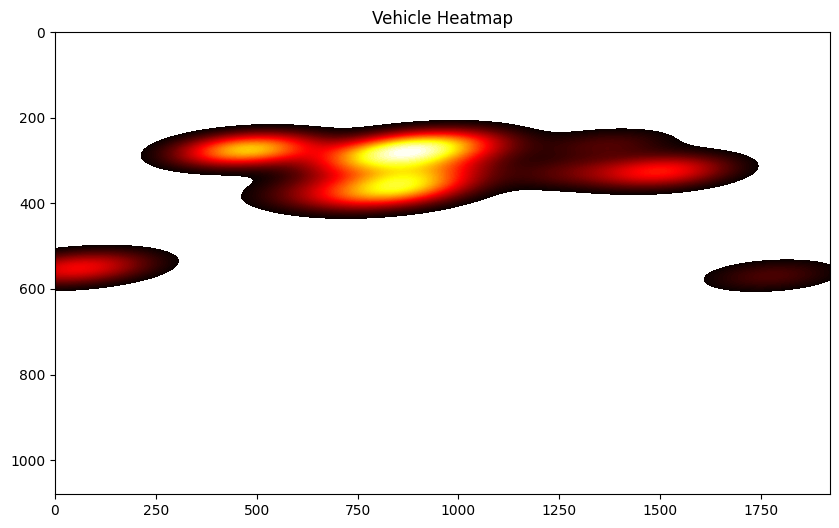

Interrupted manually. Stopping.


In [25]:
# Open stream
cap = cv2.VideoCapture(stream_url)

# Define COCO class IDs for all vehicle types
TARGET_CLASSES = {
    2: ('Car', (0, 255, 0)),
    3: ('Motorcycle', (255, 255, 0)),
    5: ('Bus', (255, 0, 0)),
    7: ('Truck', (0, 0, 255))
}

# List to hold detected centers over time
all_detections = []

def draw_heatmap(points, frame_shape):
    if not points:
        print("No detections yet for heatmap.")
        return
    xs, ys = zip(*points)

    # Create heatmap using seaborn
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=xs, y=ys, fill=True, cmap='hot', bw_adjust=0.5, levels=100, thresh=0.05)
    plt.title('Vehicle Heatmap')
    plt.xlim(0, frame_shape[1])
    plt.ylim(frame_shape[0], 0)  # invert Y axis to match image
    plt.show()

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            time.sleep(2)
            continue

        # Convert BGR to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Run YOLO detection
        results = model(rgb_frame, verbose=False)

        # Annotate and collect centers
        for result in results:
            boxes = result.boxes
            for box in boxes:
                cls_id = int(box.cls[0])
                conf = float(box.conf[0])
                if cls_id in TARGET_CLASSES and conf > 0.3:
                    xyxy = box.xyxy[0].cpu().numpy().astype(int)
                    x_center = int((xyxy[0] + xyxy[2]) / 2)
                    y_center = int((xyxy[1] + xyxy[3]) / 2)
                    all_detections.append((x_center, y_center))

                    label_name, color = TARGET_CLASSES[cls_id]
                    # Draw bounding box
                    cv2.rectangle(frame, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), color, 2)
                    label = f"{label_name} {conf:.2f}"
                    cv2.putText(frame, label, (xyxy[0], xyxy[1] - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Display annotated frame
        clear_output(wait=True)
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Live Vehicle Detection')
        plt.show()

        # OPTIONAL: Display heatmap every N iterations
        if len(all_detections) >= 30:
            print(f"Rendering heatmap with {len(all_detections)} points...")
            draw_heatmap(all_detections, frame.shape)

        # Wait before next frame
        time.sleep(5)

except KeyboardInterrupt:
    print("Interrupted manually. Stopping.")
finally:
    cap.release()

This works already. Let's implement some tweaks to the heatmap and overlay it with the actual picture - so that the results are more visible:

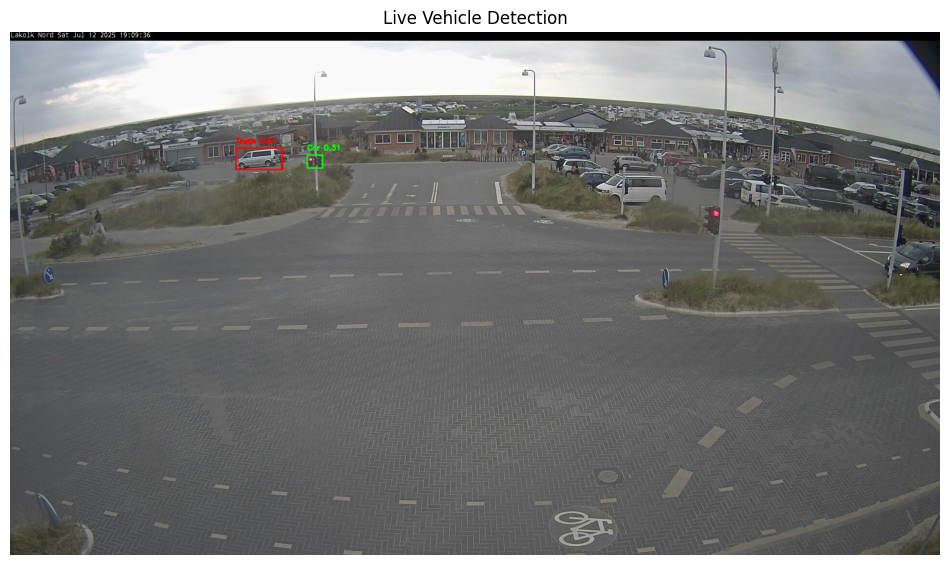

Rendering heatmap with 55 points...


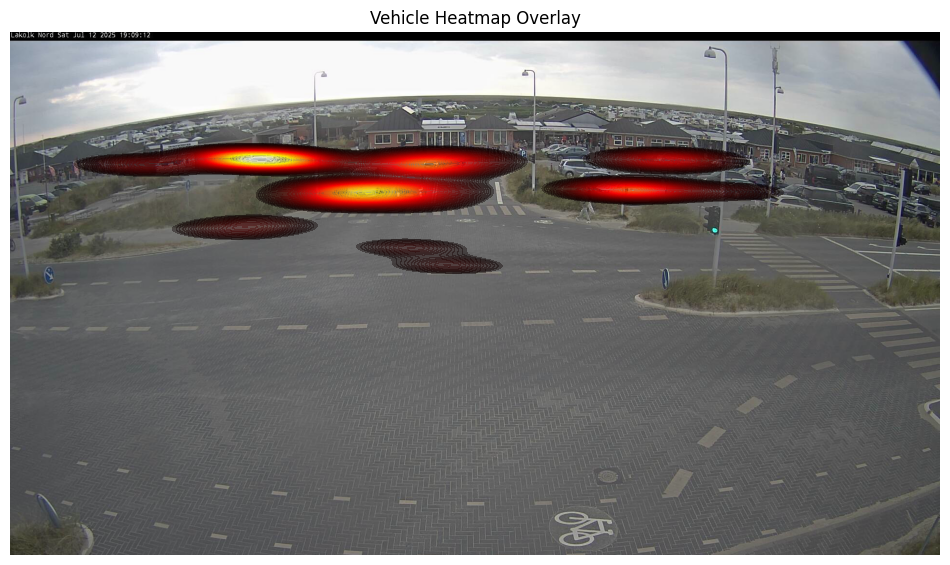

Interrupted manually. Stopping.


In [27]:
# Open stream
cap = cv2.VideoCapture(stream_url)

# Define COCO class IDs for all vehicle types
TARGET_CLASSES = {
    2: ('Car', (0, 255, 0)),
    3: ('Motorcycle', (255, 255, 0)),
    5: ('Bus', (255, 0, 0)),
    7: ('Truck', (0, 0, 255))
}

# Collect detected centers over time
all_detections = []

# 1️⃣ Capture one background reference frame (for overlay)
print("Capturing reference background frame...")
ret, background_frame = cap.read()
if not ret:
    print("Failed to capture background frame! Exiting.")
    cap.release()
else:
    background_image = cv2.cvtColor(background_frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,6))
    plt.imshow(background_image)
    plt.title("Reference Background Frame")
    plt.axis('off')
    plt.show()

    print("Background frame captured successfully.")

# 2️⃣ Define a heatmap drawing function with overlay
def draw_heatmap_overlay(points, background_image):
    if not points:
        print("No detections yet for heatmap.")
        return

    xs, ys = zip(*points)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(background_image)

    sns.kdeplot(
        x=xs, y=ys,
        fill=True,
        cmap='hot',
        bw_adjust=0.5,
        levels=100,
        thresh=0.05,
        alpha=0.4  # TRANSPARENCY of heatmap overlay
    )

    ax.set_title('Vehicle Heatmap Overlay')
    ax.axis('off')
    plt.show()

# 3️⃣ Continuous Detection Loop
try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            time.sleep(2)
            continue

        # Convert BGR to RGB for YOLO
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Run YOLO detection
        results = model(rgb_frame, verbose=False)

        # Annotate detections and collect centers
        for result in results:
            boxes = result.boxes
            for box in boxes:
                cls_id = int(box.cls[0])
                conf = float(box.conf[0])
                if cls_id in TARGET_CLASSES and conf > 0.3:
                    xyxy = box.xyxy[0].cpu().numpy().astype(int)
                    x_center = int((xyxy[0] + xyxy[2]) / 2)
                    y_center = int((xyxy[1] + xyxy[3]) / 2)
                    all_detections.append((x_center, y_center))

                    label_name, color = TARGET_CLASSES[cls_id]
                    # Draw box and label
                    cv2.rectangle(frame, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), color, 2)
                    label = f"{label_name} {conf:.2f}"
                    cv2.putText(frame, label, (xyxy[0], xyxy[1] - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Show live annotated frame
        clear_output(wait=True)
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Live Vehicle Detection')
        plt.show()

        # Periodically display heatmap overlay
        if len(all_detections) % 5 == 0 and len(all_detections) > 0:
            print(f"Rendering heatmap with {len(all_detections)} points...")
            draw_heatmap_overlay(all_detections, background_image)

        time.sleep(5)

except KeyboardInterrupt:
    print("Interrupted manually. Stopping.")
finally:
    cap.release()